#Feature Engineering para datos numéricos



## Importar librerias y definir configuraciones


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as spstats
import io

%matplotlib inline
mpl.style.reload_library()
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = (1, 1, 1, 0)
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 100

# Mediciones en crudo

## Valores

In [2]:
from google.colab import files
data_to_load = files.upload()

ModuleNotFoundError: No module named 'google'

In [ ]:
poke_df = pd.read_csv(io.BytesIO(data_to_load['Pokemon.csv']))
poke_df.head()

In [ ]:
poke_df[['HP', 'Attack', 'Defense']].head()

In [ ]:
poke_df[['HP', 'Attack', 'Defense']].describe()

## Cuentas

In [ ]:
data_to_load = files.upload()
popsong_df = pd.read_csv(io.BytesIO(data_to_load['song_views.csv']))
popsong_df.head(10)

# Binarización

A menudo, las frecuencias numéricas o los recuentos no son necesarios en la construcción de modelos, especialmente con respecto a
métodos aplicados en la construcción de sistemas de recomendación. Por ejemplo si quiero saber si una persona está interesada
o ha escuchado una canción en particular, no necesito saber el número total de veces que la ha escuchado. Me preocupan más las distintas canciones que ha escuchado. En este caso, una característica binaria es preferible. Podemos binarizar el campo listen_count de nuestro conjunto de datos anterior de la siguiente manera.

In [ ]:
escuchada = np.array(popsong_df['listen_count']) 
escuchada[escuchada >= 1] = 1
popsong_df['escuchada'] = escuchada
popsong_df.head(10)

In [ ]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold=0.9)
bin_escuchada = bn.transform([popsong_df['listen_count']])[0]
popsong_df['bin_escuchada'] = bin_escuchada
popsong_df.head(11)

# Redondeo

A menudo, cuando se trata de atributos numéricos como proporciones o porcentajes, puede que no necesitemos valores con una 
precisión elevada. Por lo tanto, tiene sentido redondear estos porcentajes de alta precisión en números enteros. Estos enteros pueden utilizarse directamente como valores numéricos crudos o incluso como características categóricas (basadas en clases discretas).Intentemos aplicar este concepto en un conjunto de datos ficticio que represente los artículos de la tienda y sus 
porcentajes de popularidad


In [ ]:
data_to_load = files.upload()
items_popularity = pd.read_csv(io.BytesIO(data_to_load['item_popularity.csv']))
items_popularity

In [ ]:
items_popularity['popularity_scale_10'] = np.array(np.round((items_popularity['pop_percent'] * 10)), dtype='int')
items_popularity['popularity_scale_100'] = np.array(np.round((items_popularity['pop_percent'] * 100)), dtype='int')
items_popularity

# Interacciones

Un modelo suele construirse de forma que se intenta modelar las respuestas de salida (clases discretas o 
valores continuos) en función de las variables de entrada. Por ejemplo, una ecuación de regresión lineal simple 
lineal simple puede representarse como:

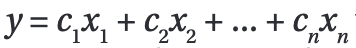

donde las características de entrada están representadas por las variables {x1, x2,..., xn} con pesos o coeficientes {c1, c2,..., cn} respectivamente y el objetivo es predecir la respuesta y.  
En este caso, este modelo lineal simple describe la relación entre la salida y las entradas, basándose únicamente en las 
características de entrada individuales y separadas.
Sin embargo, a menudo, en varios conjuntos de datos y escenarios del mundo real, tiene sentido intentar capturar también las 
interacciones entre estas variables de características como parte del conjunto de características de entrada. Una representación sencilla de la 
extensión de la formulación de regresión lineal anterior con características de interacción sería


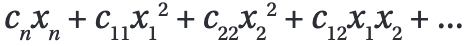

In [ ]:
atk_def = poke_df[['Attack', 'Defense']]
atk_def.head()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
res = pf.fit_transform(atk_def)
res

In [ ]:
pd.DataFrame(pf.powers_, columns=['Attack_degree', 'Defense_degree'])

Le damos un nombre adecuado a cada nueva feature

In [ ]:
intr_features = pd.DataFrame(res, columns=['Attack', 'Defense', 'Attack^2', 'Attack x Defense', 'Defense^2'])
intr_features.head(5)  

La función fit_transform(...) 
de scikit-learn es útil para construir un objeto con los datos de entrenamiento 
que puede ser reutilizado en nuevos datos durante las predicciones del modelo llamando a la función transform(...). 
Tomemos algunas observaciones nuevas de ejemplo para las características de ataque y defensa de los Pokémon e intentemos transformarlas 
utilizando este mismo mecanismo


In [ ]:
new_df = pd.DataFrame([[95, 75],[121, 120], [77, 60]], 
                      columns=['Attack', 'Defense'])
new_df

In [ ]:
new_res = pf.transform(new_df)
new_intr_features = pd.DataFrame(new_res, 
                                 columns=['Attack', 'Defense', 
                                          'Attack^2', 'Attack x Defense', 'Defense^2'])
new_intr_features

# Binning

A menudo, al trabajar con datos numéricos, es posible que se encuentre con características o atributos que representan medidas sin procesar, como valores o frecuencias. En muchos casos, las distribuciones de estos atributos están sesgadas en el sentido de que algunos conjuntos de valores ocurrirán mucho y algunos serán muy raros. Además de eso, también existe el problema añadido de variar el rango de estos valores. Supongamos que estamos hablando de conteo de reproducciones de canciones o videos. En algunos casos, el conteo de vistas será anormalmente grande y en algunos casos muy pequeño. El uso directo de estas funciones en el modelado puede causar problemas. Las métricas como las medidas de similitud, las distancias de los clusters, los coeficientes de regresión y otras podrían verse afectadas negativamente si usamos características numéricas sin procesar que tengan valores que abarquen varios órdenes de magnitud. Hay varias formas de diseñar características a partir de estos valores sin procesar para poder resolver estos problemas. Estos métodos incluyen transformaciones, escalado y agrupamiento / cuantificación.

In [ ]:
fcc_survey_df = pd.read_csv('fcc_2016_coder_survey_subset.csv', encoding='utf-8')
fcc_survey_df[['ID.x', 'EmploymentField', 'Age', 'Income']].head()

## Binning de ancho fijo


### Distribution de edades

In [ ]:
fig, ax = plt.subplots()
fcc_survey_df['Age'].hist(color='#A9C5D3')
ax.set_title('Developer Age Histogram', fontsize=12)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

### Binning basado en redondeo

``` 
Age Range: Bin
---------------
 0 -  9  : 0
10 - 19  : 1
20 - 29  : 2
30 - 39  : 3
40 - 49  : 4
50 - 59  : 5
60 - 69  : 6
  ... and so on
```

In [ ]:
fcc_survey_df['Age_bin_round'] = np.array(np.floor(np.array(fcc_survey_df['Age']) / 10.))
fcc_survey_df[['ID.x', 'Age', 'Age_bin_round']].iloc[1071:1076]

### Binning basado en rangos personalizados

``` 
Age Range : Bin
---------------
 0 -  15  : 1
16 -  30  : 2
31 -  45  : 3
46 -  60  : 4
61 -  75  : 5
75 - 100  : 6
```

In [ ]:
bin_ranges = [0, 15, 30, 45, 60, 75, 100]
bin_names = [1, 2, 3, 4, 5, 6]
fcc_survey_df['Age_bin_custom_range'] = pd.cut(np.array(fcc_survey_df['Age']), 
                                               bins=bin_ranges)
fcc_survey_df['Age_bin_custom_label'] = pd.cut(np.array(fcc_survey_df['Age']), 
                                               bins=bin_ranges, labels=bin_names)
fcc_survey_df[['ID.x', 'Age', 'Age_bin_round', 
               'Age_bin_custom_range', 'Age_bin_custom_label']].iloc[1071:1076]

## Binning basado en cuantiles 

El binning basado en cuantiles es una buena estrategia para el binning adaptativo. Los cuantiles son valores específicos o puntos de corte que ayudan a dividir la distribución de valores continuos de un campo numérico específico en intervalos discretos y contiguos. Así, los q-cuantiles ayudan a dividir un atributo numérico en q particiones iguales. Ejemplos populares de cuantiles incluyen el 2-cuantil conocido como la mediana que divide la distribución de datos en dos intervalos iguales, 4-cuantiles conocidos como los cuartiles, que dividen los datos en cuatro intervalos iguales y 10-cuantiles también conocidos como los deciles que crean 10 intervalos de igual ancho. Veamos ahora una porción de datos correspondientes a los valores de ingresos de los desarrolladores en los datos de nuestra encuesta de codificadores


In [ ]:
fcc_survey_df[['ID.x', 'Age', 'Income']].iloc[4:9]

In [ ]:
fig, ax = plt.subplots()
fcc_survey_df['Income'].hist(bins=30, color='#A9C5D3')
ax.set_title('Developer Income Histogram', fontsize=12)
ax.set_xlabel('Developer Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [ ]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = fcc_survey_df['Income'].quantile(quantile_list)
quantiles

In [ ]:
fig, ax = plt.subplots()
fcc_survey_df['Income'].hist(bins=30, color='#A9C5D3')

for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)

ax.set_title('Developer Income Histogram with Quantiles', fontsize=12)
ax.set_xlabel('Developer Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [ ]:
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
fcc_survey_df['Income_quantile_range'] = pd.qcut(fcc_survey_df['Income'], 
                                                 q=quantile_list)
fcc_survey_df['Income_quantile_label'] = pd.qcut(fcc_survey_df['Income'], 
                                                 q=quantile_list, labels=quantile_labels)
fcc_survey_df[['ID.x', 'Age', 'Income', 
               'Income_quantile_range', 'Income_quantile_label']].iloc[4:9]

# Transformaciones matematicas




## Logaritmo

Las transformaciones logaritmicas son útiles cuando se aplican a distribuciones sesgadas, ya que tienden a expandir los valores que caen en el rango de las magnitudes más bajas y tienden a comprimir o reducir los valores que caen en el rango de las magnitudes más altas. Esto tiende a hacer que la distribución sesgada sea lo más normal posible. 

In [ ]:
fcc_survey_df['Income_log'] = np.log((1+ fcc_survey_df['Income']))
fcc_survey_df[['ID.x', 'Age', 'Income', 'Income_log']].iloc[4:9]

In [ ]:
income_log_mean = np.round(np.mean(fcc_survey_df['Income_log']), 2)

fig, ax = plt.subplots()
fcc_survey_df['Income_log'].hist(bins=30, color='#A9C5D3')
plt.axvline(income_log_mean, color='r')
ax.set_title('Developer Income Histogram after Log Transform', fontsize=12)
ax.set_xlabel('Developer Income (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(income_log_mean), fontsize=10)

#Feature Engineering para datos categóricos

Los datos categóricos nominales son tales que no existe el concepto de orden entre los valores, es decir, no tiene sentido clasificarlos u ordenarlos. Los géneros de películas o videojuegos, las estaciones del año y los nombres de los países son algunos ejemplos de atributos nominales. Las variables categóricas ordinales pueden ordenarse y clasificarse en función de sus valores y, por lo tanto, estos valores tienen un significado específico que hace que su orden tenga sentido. Algunos ejemplos de atributos ordinales son la talla de ropa, el nivel educativo, etc.


# Transformando características nominales




In [ ]:
vg_df = pd.read_csv('vgsales.csv', encoding='utf-8')
vg_df[['Name', 'Platform', 'Year', 'Genre', 'Publisher']].iloc[1:7]

In [ ]:
genres = np.unique(vg_df['Genre'])
genres

In [ ]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
genre_labels = gle.fit_transform(vg_df['Genre'])
genre_mappings = {index: label for index, label in enumerate(gle.classes_)}
genre_mappings

In [ ]:
vg_df['GenreLabel'] = genre_labels
vg_df[['Name', 'Platform', 'Year', 'Genre', 'GenreLabel']].iloc[1:7]

# Transformando características ordinales

Las características ordinales son similares a las nominales, salvo que el orden importa y es una propiedad inherente con la que podemos interpretar los valores de estas características. Al igual que los datos nominales, incluso los datos ordinales pueden estar presentes en forma de texto y es necesario mapearlos y transformarlos en su representación numérica. Carguemos ahora nuestro conjunto de datos de Pokémon que utilizamos antes y veamos los distintos valores del atributo **Generación** de cada Pokémon.


In [ ]:
poke_df = pd.read_csv('Pokemon.csv', encoding='utf-8')
poke_df = poke_df.sample(random_state=1, frac=1).reset_index(drop=True)

np.unique(poke_df['Generation'])

In [ ]:
gen_ord_map = {'Gen 1': 1, 'Gen 2': 2, 'Gen 3': 3, 
               'Gen 4': 4, 'Gen 5': 5, 'Gen 6': 6}

poke_df['GenerationLabel'] = poke_df['Generation'].map(gen_ord_map)
poke_df[['Name', 'Generation', 'GenerationLabel']].iloc[4:10]

# Codificando características categóricas

## One-hot Encoding

In [ ]:
poke_df[['Name', 'Generation', 'Legendary']].iloc[4:10]

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

gen_le = LabelEncoder()
gen_labels = gen_le.fit_transform(poke_df['Generation'])
poke_df['Gen_Label'] = gen_labels

leg_le = LabelEncoder()
leg_labels = leg_le.fit_transform(poke_df['Legendary'])
poke_df['Lgnd_Label'] = leg_labels

poke_df_sub = poke_df[['Name', 'Generation', 'Gen_Label', 'Legendary', 'Lgnd_Label']]
poke_df_sub.iloc[4:10]

In [ ]:
gen_ohe = OneHotEncoder()
gen_feature_arr = gen_ohe.fit_transform(poke_df[['Gen_Label']]).toarray()
gen_feature_labels = list(gen_le.classes_)
gen_features = pd.DataFrame(gen_feature_arr, columns=gen_feature_labels)

leg_ohe = OneHotEncoder()
leg_feature_arr = leg_ohe.fit_transform(poke_df[['Lgnd_Label']]).toarray()
leg_feature_labels = ['Legendary_'+str(cls_label) for cls_label in leg_le.classes_]
leg_features = pd.DataFrame(leg_feature_arr, columns=leg_feature_labels)

In [ ]:
poke_df_ohe = pd.concat([poke_df_sub, gen_features, leg_features], axis=1)
columns = sum([['Name', 'Generation', 'Gen_Label'],gen_feature_labels,
              ['Legendary', 'Lgnd_Label'],leg_feature_labels], [])
poke_df_ohe[columns].iloc[4:10]

In [ ]:
new_poke_df = pd.DataFrame([['PikaZoom', 'Gen 3', True], 
                           ['CharMyToast', 'Gen 4', False]],
                           columns=['Name', 'Generation', 'Legendary'])
new_poke_df

In [ ]:
new_gen_labels = gen_le.transform(new_poke_df['Generation'])
new_poke_df['Gen_Label'] = new_gen_labels

new_leg_labels = leg_le.transform(new_poke_df['Legendary'])
new_poke_df['Lgnd_Label'] = new_leg_labels

new_poke_df[['Name', 'Generation', 'Gen_Label', 'Legendary', 'Lgnd_Label']]

In [ ]:
new_gen_feature_arr = gen_ohe.transform(new_poke_df[['Gen_Label']]).toarray()
new_gen_features = pd.DataFrame(new_gen_feature_arr, columns=gen_feature_labels)

new_leg_feature_arr = leg_ohe.transform(new_poke_df[['Lgnd_Label']]).toarray()
new_leg_features = pd.DataFrame(new_leg_feature_arr, columns=leg_feature_labels)

new_poke_ohe = pd.concat([new_poke_df, new_gen_features, new_leg_features], axis=1)
columns = sum([['Name', 'Generation', 'Gen_Label'], gen_feature_labels,
               ['Legendary', 'Lgnd_Label'], leg_feature_labels], [])
new_poke_ohe[columns]

In [ ]:
gen_onehot_features = pd.get_dummies(poke_df['Generation'])
pd.concat([poke_df[['Name', 'Generation']], gen_onehot_features], axis=1).iloc[4:10]

## Codificación **Dummy**

In [ ]:
gen_dummy_features = pd.get_dummies(poke_df['Generation'], drop_first=True)
pd.concat([poke_df[['Name', 'Generation']], gen_dummy_features], axis=1).iloc[4:10]

In [ ]:
gen_onehot_features = pd.get_dummies(poke_df['Generation'])
gen_dummy_features = gen_onehot_features.iloc[:,:-1]
pd.concat([poke_df[['Name', 'Generation']], gen_dummy_features], axis=1).iloc[4:10]

## Codificación **Efecto**

In [ ]:
gen_onehot_features = pd.get_dummies(poke_df['Generation'])
gen_effect_features = gen_onehot_features.iloc[:,:-1]
gen_effect_features.loc[np.all(gen_effect_features == 0, axis=1)] = -1.
pd.concat([poke_df[['Name', 'Generation']], gen_effect_features], axis=1).iloc[4:10]

## Feature Hashing

El esquema de hash de características es otro esquema de ingeniería de características útil para tratar con características categóricas a gran escala. En este esquema se suele utilizar una función hash con el número de características codificadas preestablecido (como un vector de longitud predefinida) de manera que los valores hash de las características se utilizan como índices en este vector predefinido y los valores se actualizan en consecuencia. Dado que una función hash asigna un gran número de valores a un pequeño conjunto finito de valores, varios valores diferentes pueden crear el mismo hash, lo que se denomina colisiones. Normalmente, se utiliza una función hash con signo para que el signo del valor obtenido del hash se utilice como signo del valor que se almacena en el vector de características final en el índice apropiado. Los esquemas de hash funcionan con cadenas, números y otras estructuras como vectores. Se puede pensar en las salidas con hash como un conjunto finito de h bins, de manera que cuando se aplica la función hash a los mismos valores, éstos se asignan al mismo bin de los h bins basándose en el valor hash. Podemos asignar el valor de h, que se convierte en el tamaño final del vector de características codificado para cada característica categórica que codificamos utilizando el esquema de hash de características.

In [ ]:
unique_genres = np.unique(vg_df[['Genre']])
print("Total game genres:", len(unique_genres))
print(unique_genres)

In [ ]:
from sklearn.feature_extraction import FeatureHasher

fh = FeatureHasher(n_features=6, input_type='string')
hashed_features = fh.fit_transform(vg_df['Genre'])
hashed_features = hashed_features.toarray()
pd.concat([vg_df[['Name', 'Genre']], pd.DataFrame(hashed_features)], axis=1).iloc[1:7]

In [ ]:
fh.get_params()

## Tambien se puede hacer ingeniería de características en:

*   Datos de texto
*   Datos de imagen
*   Datos temporales (series de tiempo)

